In [35]:
from data_helper import load_dump
from topic_analysis import *
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.svm import SVC
import numpy as np
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

Populating the interactive namespace from numpy and matplotlib


/home/yevhen/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
Xtrain = load_dump("train_pt_new")
Xdev = load_dump("dev_pt_new")

Ytrain = load_dump("Ytrain_new")
Ydev = load_dump("Ydev_new")

In [4]:
from sklearn.utils import shuffle
trainX, trainY = shuffle(Xtrain, Ytrain)
devX, devY = shuffle(Xdev, Ydev)
trainX, trainY = Xtrain, Ytrain
devX, devY = Xdev, Ydev

In [5]:
vec = CountVectorizer(max_features=100000, min_df=3, max_df=0.8)

In [7]:
vec.fit(trainX+devX)
vec_all = vec.transform(trainX+devX)
vec_trn = vec.transform(trainX)
vec_dev = vec.transform(devX)

In [6]:
colors = cm.rainbow(np.linspace(0, 1, num_topics))

NameError: name 'num_topics' is not defined

# Logistic regression

In [157]:
from sklearn.model_selection import GridSearchCV

In [158]:
clf_lr = LogisticRegression()
clf_lr.fit(train_pt, trainY)
print(clf_lr.score(train_pt, trainY))
print(clf_lr.score(dev_pt, devY))
lr_preds = clf_lr.predict(dev_pt)
confusion_matrix(devY, lr_preds).ravel()


0.9414639564589581
0.559981684981685


array([308, 866,  95, 915])

In [159]:
print(precision_score(devY, lr_preds))
print(recall_score(devY, lr_preds))
print(np.mean(devY == lr_preds))

0.5137563166760247
0.905940594059406
0.559981684981685


# Naive Bayes: LDA features

tn, fp, fn, tp

In [160]:
clf_nb = MultinomialNB()
clf_nb.fit(train_pt, trainY)
print(clf_nb.score(train_pt, trainY))
print(clf_nb.score(dev_pt, devY))
nb_preds = clf_nb.predict(dev_pt)
confusion_matrix(devY, nb_preds).ravel()

0.9343552149283573
0.5457875457875457


array([279, 895,  97, 913])

# Naive Bayes: TFIDF features

In [43]:
# all_data = trainX+devX

In [51]:
# tfidf = TfidfVectorizer()
# tfidf.fit(all_data)

In [52]:
# tfidf_train = tfidf.transform(trainX)
# tfidf_dev = tfidf.transform(devX)
# print(tfidf_train[0])
# 

In [53]:
# nb_tfidf = MultinomialNB()
# nb_tfidf.fit(tfidf_train, trainY)
# print(clf_nb.score(tfidf_train, trainY))
# print(clf_nb.score(tfidf_dev, devY))
# tfnb_preds = clf_nb.predict(tfidf_dev)
# conf_matr = confusion_matrix(devY, tfnb_preds).ravel()
# conf_matr

# SVM

In [ ]:
def svm_param_search(data, labels, folds):
    Cs = [0.001, 0.01, 0.1, 0.5, 1, 2, 3, 4, 5, 6, 7, 13, 15, 17, 21, 23, 25, 27]
    gammas = [0.01, 0.05, 0.1, 0.5, 1, 2, 10, 15]
    param_grid = {'C': Cs, 'gamma': gammas}
    grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=folds)
    grid_search.fit(data, labels)
    grid_search.best_params_
    return grid_search.best_params_

In [ ]:
svm_param_search(train_pt, trainY, 7)

In [173]:
clf_svm = SVC(C=0.01, gamma=10, kernel="rbf")
clf_svm.fit(train_pt, trainY)
print(clf_svm.score(train_pt, trainY))
print(clf_svm.score(dev_pt, devY))
svm_preds = clf_svm.predict(dev_pt)
confusion_matrix(devY, svm_preds).ravel()


0.9012551371764967
0.7147435897435898


array([845, 329, 294, 716])

# Topic number search

In [38]:
topics_grid = [5, 10, 15, 20, 30, 40, 50, 60, 75, 80, 100]
all_scores = {}
best_scores = {}
best_score = 0
best_lda = None

In [ ]:
for topic_number in topics_grid:
    lda_tune = LatentDirichletAllocation(n_components=topic_number, learning_method='batch', random_state=10)
    print("Fitting LDA with", topic_number, "topics")
    lda_tune.fit(vec_all)
    train_pt = lda_tune.transform(vec_trn)
    dev_pt = lda_tune.transform(vec_dev)
    
    svm = SVC(C=0.01, gamma=10, kernel="rbf")
    svm.fit(train_pt, trainY)
    curr_score = svm.score(dev_pt, devY)
    print("Current score", curr_score)
    print("--------------------------\n")
    
    all_scores[topic_number] = curr_score
    
    if curr_score > best_score:
        best_scores[topic_number] = curr_score
        best_score = curr_score
        best_lda = lda_tune


Fitting LDA with 5 topics
Current score 0.5444139194139194
--------------------------

Fitting LDA with 10 topics
Current score 0.5247252747252747
--------------------------

Fitting LDA with 15 topics
Current score 0.6126373626373627
--------------------------

Fitting LDA with 20 topics
Current score 0.6309523809523809
--------------------------

Fitting LDA with 30 topics
Current score 0.7673992673992674
--------------------------

Fitting LDA with 40 topics
Current score 0.6675824175824175
--------------------------

Fitting LDA with 50 topics
Current score 0.5943223443223443
--------------------------

Fitting LDA with 60 topics


In [ ]:
svc = SVC(C=0.01, gamma=10, kernel="rbf")


In [12]:
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

In [10]:
best_scores

{5: 0.5444139194139194,
 15: 0.6126373626373627,
 20: 0.6309523809523809,
 30: 0.7673992673992674}

In [27]:
all_scores

[(5, 0.5444139194139194),
 (10, 0.5247252747252747),
 (15, 0.6126373626373627),
 (20, 0.6309523809523809),
 (30, 0.7673992673992674),
 (40, 0.6675824175824175),
 (50, 0.5943223443223443),
 (60, 0.5412087912087912),
 (75, 0.5512820512820513),
 (80, 0.6662087912087912),
 (100, 0.5970695970695971)]

In [32]:
# all_scores = [(k, v) for k,v in all_scores.items()]
all_scores[0]

(5, 0.5444139194139194)

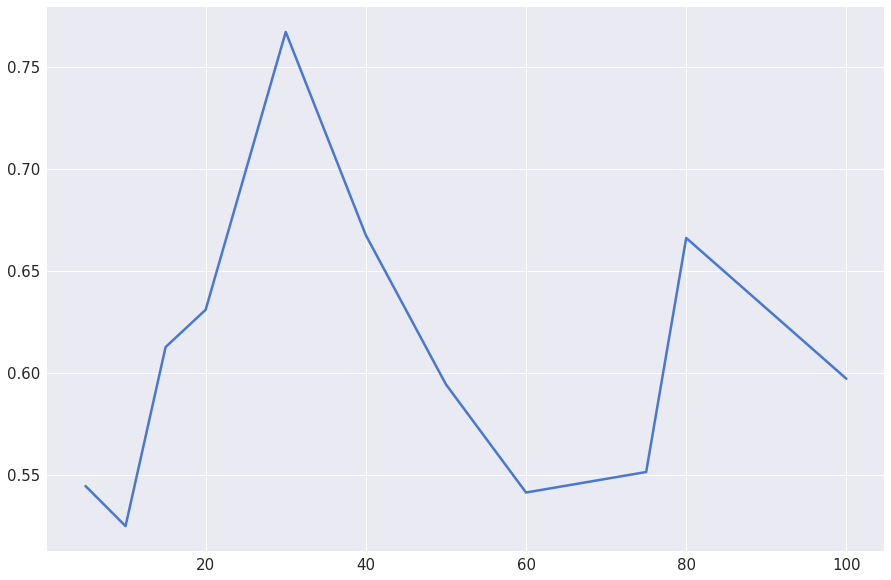

In [36]:
plt.plot([all_scores[i][0] for i in range(len(all_scores))], [all_scores[i][1] for i in range(len(all_scores))])

In [107]:
from collections import Counter

In [108]:
c = Counter()
Counter(trainY)


Counter({0: 4457, 1: 4546})

In [93]:
Counter(devY)

Counter({0: 1174, 1: 1010})

In [ ]:
, min_df=3, max_df=0.7